In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rapid intro to Reinforcement Learning (Q-learning)

The explanations and examples of this notebook are follow closely the book ["Reinforcement Learning" by Sutton&Barto](http://incompleteideas.net/book/RLbook2020.pdf). The discussion of the math in this notebook is largely sketchy, see the book for details.

In Reinforcement Learning (RL) an **agent** is trained to achieve some task by interacting with an **environment**. The agent can take **actions** that influence the environment. After taking an action, the agent receives some information about the new **state** of the environment and a **reward** indicating the usefulness of the action with respect to the goal of achieving the given task.

<img src="https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg"></img>

The dynamics of the environment is not necessarily deterministic, meaning that when in state $S_t$ the action $A_t$ taken by the agent leads to a new state $S_{t+1}$ and reward $R_{t+1}$ with a probability $p(S_{t+1},R_{t+1}|S_t,A_t)$.

In choosing its actions the agent follows a policy $\pi(A_{t+1}|S_t)$, which is the probability of choosing each of the actions $A_{t+1}$ given the current state $S_t$. The dynamics resulting from this agent-environment-interaction is called a **Markov Decision Process** (MDP) and takes the form

$$
S_0\overset{\pi}{\to}A_0\overset{p}{\to}S_1,R_1\overset{\pi}{\to}A_1\overset{p}{\to}S_1,R_1\overset{\pi}{\to}\ldots
$$

**Training the agent means maximizing the expected return**, which is the accumulated (discounted) reward

$$
    G_t = \sum_k\gamma^k R_{t+k+1}
$$

where $0\leq\gamma\leq1$ is the *discount rate*.

## The value function

The **value function** $v_{\pi}(s)$ is defined as the expected return when starting from state $s$ and subsequently following the policy $\pi$

$$
v_\pi(s)=\mathbb E_\pi[G_t|S_t=s]=\mathbb E_\pi\Big[\sum_k\gamma^k R_{t+k+1}|S_t=s\Big]
$$

The value function fulfills a self-consistency equation, the **Bellman equation**

$$
\begin{aligned}
v_\pi(s)&=\mathbb E_\pi[G_t|S_t=s]
=\mathbb E_\pi[R_{t+1}+\gamma G_{t+1}|S_t=s]
=\sum_a\pi(a|s)\sum_{s',r}p(s',r|s,a)\big[r+\gamma v_\pi(s')\big]
\end{aligned}
$$

### Finding the value function for a grid world

Grid worlds are simple environments that we can use for basic examples of RL.

Let's consider the following rules:

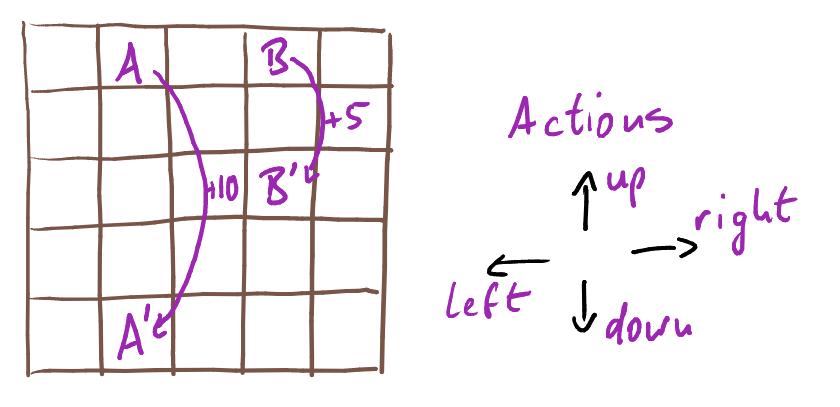

The agent is located on a 5$\times$5 grid world. From each location of the grid it can take the actions "left", "right", "up", or "down". As a result of the action, the agent is moved to the corresponding neigboring cell on the grid and receives a reward 0. If the action would take the agent off the grid, its location remains unchanged and the reward -1 is given. The cells marked with `A` and `B` are special: From these cells any action takes the agent to location `A'` or `B'` with reward 10 or 5, respectively.

The following cell defines an environment that returns the new position on the grid, i.e. new state $S_{t+1}$, and reward $R_{t+1}$ when taking action $A_t$ in state $S_t$:

In [ ]:
# actions: 0 - up, 1 - down, 2 - left, 3 - right
def check_boundary(s,a):
    if a==0 and s<5:
        return False
    if a==1 and s>19:
        return False
    if a==2 and s%5==0:
        return False
    if a==3 and (s+1)%5==0:
        return False

    return True
    
    
def environment(s,a):
    if s==1:
        return 21, 10
    if s==3:
        return 13, 5
    
    if not check_boundary(s,a):
        return s, -1
    
    r = 0
    
    update = [-5, 5, -1, 1]
    sp = s + update[a]
    
    return sp, r

We now consider the "indifferent" policy $p(a|s)=\frac{1}{4}$ $\forall a,s$. Then we can rewrite the Bellman equation as a system of linear equations for the value function:

$$
\sum_{s'}\underbrace{\Big[\delta_{s,s'}-\frac{1}{4}\gamma\sum_{a,r}p(s',r|s,a)\Big]}_{\equiv A_{s,s'}}v_\pi(s')=\underbrace{\frac14\sum_{a,s',r}rp(s',r|s,a)}_{\equiv b_s}
$$

Hence, in order to find $v_\pi(s)$ we need to solve the linear equation

$$
    \sum_{s'}A_{s,s'}v_\pi(s')=b_s
$$

For this purpose, we construct the matrix $A$ and the vector $b$ (using the `environment` function from above):

In [ ]:
A=np.zeros((25,25))
b=np.zeros(25)
gamma=0.9

# To implement: fill the matrix A and vector b

Then we can solve for the value function:

In [ ]:
v = np.dot(np.linalg.inv(A), b)

In [ ]:
v.reshape((5,5))

#### Iterative Policy Evaluation

Alternatively, the value function can be determined in an iterative approach using the following prescription:

Loop over iterations:

&nbsp;&nbsp;&nbsp;&nbsp;Loop over all states $s$:
  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$v_\pi(s)\quad\leftarrow\quad\sum_a\pi(a|s)\sum_{s',r}p(s',r|s,a)\big[r+\gamma v_\pi(s')\big]$

We implement this prescription again assuming the "indifferent" policy $\pi(a|s)=\frac14$:

In [ ]:
v=np.zeros(25)

# To implement: iterative policy evaluation
    
v.reshape((5,5))

## Policy improvement and Q-table

The value function $v_\pi(s)$ tells us how good it is to follow the policy $\pi$ starting from state $s$. Now, we would like to determine whether there is a better policy than $\pi$. In order to do this we can consider the value of choosing an action $a$ when in state $s$, indicated by the **action-value function**

$$
q_\pi(s,a)=\mathbb E[R_{t+1}+\gamma v_\pi(S_{t+1})|S_t=s, A_t=a]=\sum_{s',r}p(s',r|s,a)\big[r+\gamma v_\pi(s')\big]
$$

Now, the optimal policy $\pi_*$ maximizes the value of a state, which is achieved by choosing the best action in that state. This leads to the **Bellman optimality equation** for the value function

$$
v_*(s)=\max_a q_{\pi_*}(s,a)=\max_a \sum_{s',r}p(s',r|s,a)\big[r+\gamma v_*(s')\big]
$$

Now, if for two *deterministic* policies $\pi$ and $\pi'$

$$
q_\pi(s,\pi'(s))\geq v_\pi(s)\quad\forall s
$$

the *policy improvement theorem* says that $\pi'$ is a better policy than $\pi$ in the sense that

$$
v_{\pi'}(s)\geq v_\pi(s)\quad\forall s
$$

This means that we can improve on any policy $\pi$ by choosing the corresponding **greedy policy**

$$
\pi'(s)=\underset{a}{\operatorname{argmax}}  q_\pi(s,a)
$$

If the greedy policy $\pi'$ is equally good as the original policy $\pi$, then $v_\pi=v_{\pi'}$ and we recover the Bellman optimality equation

$$
v_{\pi'}(s)=\max_a\sum_{s',r}p(s',r|s,a)\big[r+\gamma v_{\pi'}(s')\big]
$$

meaning that $v_{\pi'}=v_*$ and $\pi=\pi'$ is the optimal policy.

Hence, if we know the action-value function $q_{\pi}(s,a)$ of a policy $\pi$ we have the means to successively improve the policy until convergence to the optimal policy. This is the idea of Q-learning and in the following section we will see an exemplary algorithm that concurrently updates the agent's estimate of $q_{\pi}(s,a)$ and uses this as a basis to improve the current policy $\pi$.

## Windy gridworld

As an example we consider a windy grid world. This time, the agent moves on a 10$\times$7 lattice as shown below. The set of actions as well as the behavior at the boundary is identical to the previous example. However, the columns marked with $\uparrow$ or $\uparrow\uparrow$ are windy, meaning that when taking a step from these locations, the agent is in addition to the chosen action moved up by one ($\uparrow$) or two ($\uparrow\uparrow$) cells. The agent always starts in the field marked with `S` and the goal is to reach the field `G` with the least possible number of steps. For this purpose, the agent is given a reward of -1 for each action taken and the goal is to maximize the undiscounted return.

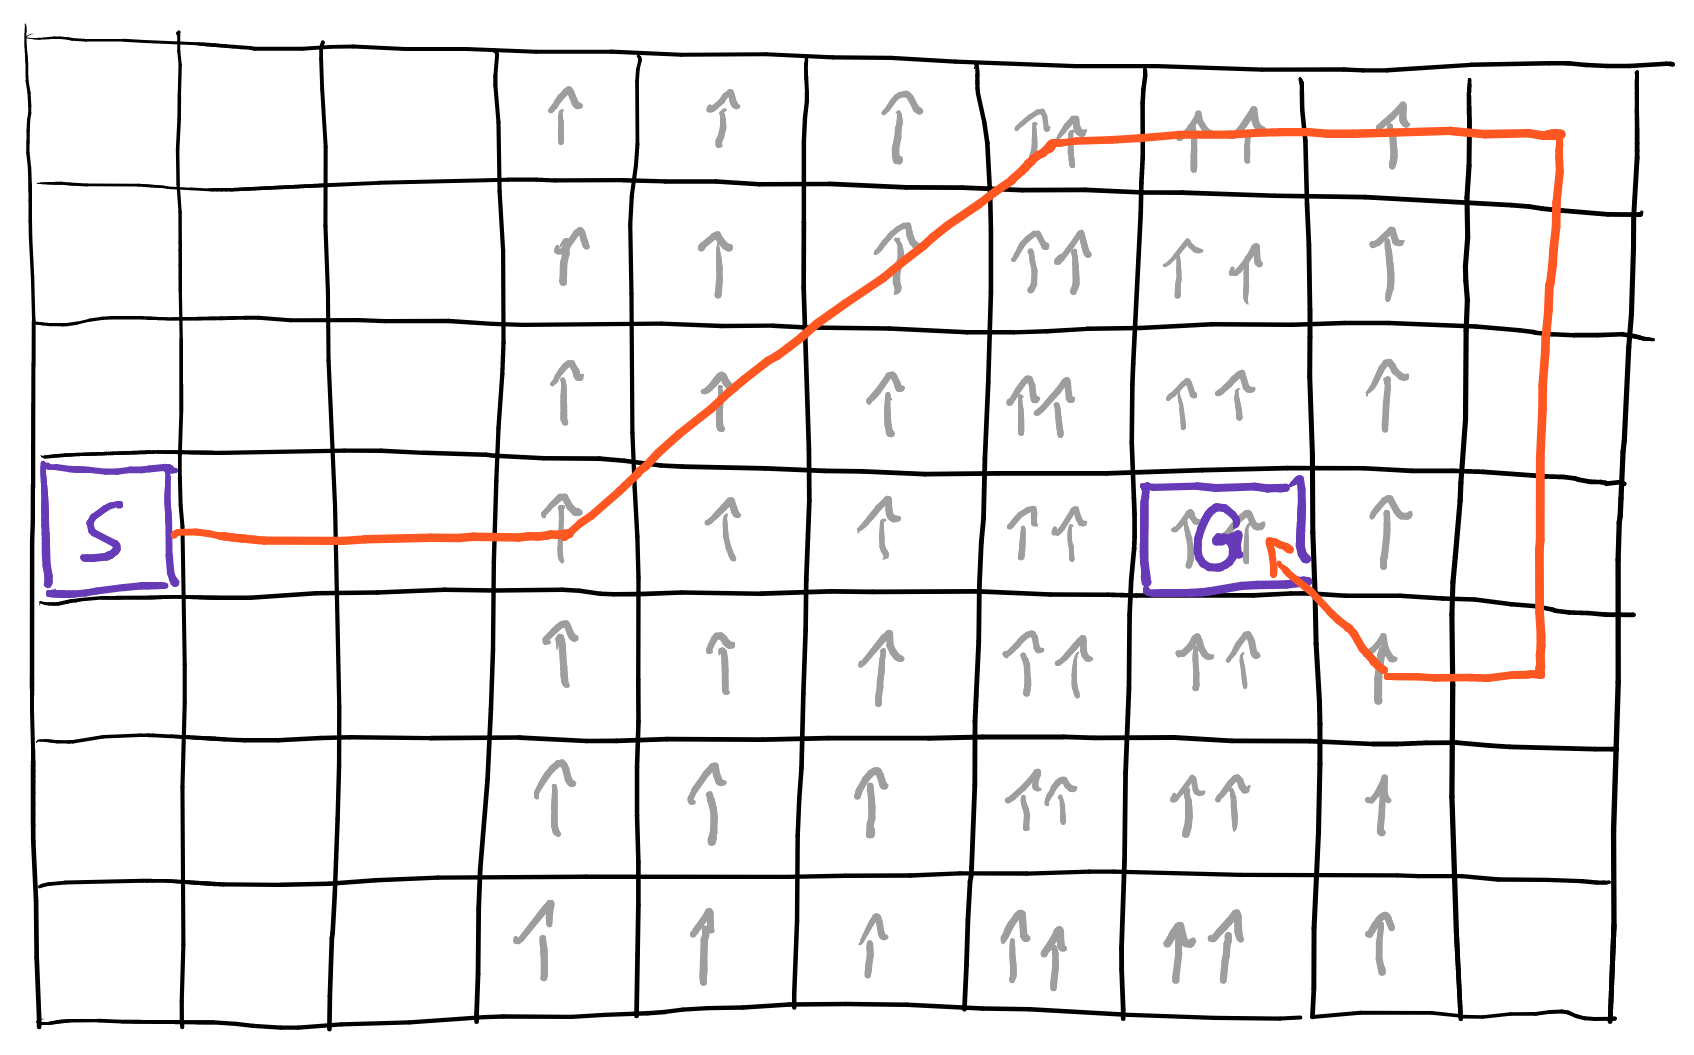

The following cell implements this environment.

In [ ]:
def check_boundary(s,a):
    width=10
    height=7
    if a==0 and s<width:
        return False
    if a==1 and s>=(height-1)*width:
        return False
    if a==2 and s%width==0:
        return False
    if a==3 and (s+1)%width==0:
        return False

    return True

def environment(s,a):
    width=10
    
    if not check_boundary(s,a):
        return s, -1
    
    update = [-width, width, -1, 1]
    col = s%width
    if col in [3,4,5,8]:
        update = [-2*width, 0, -width-1, -width+1]
    if col in [6,7]:
        update = [-3*width, -width, -2*width-1, -2*width+1]
        
    sp = s + update[a]
    
    while sp<0:
        sp += width
    
    return sp, -1

In the following we need an *$\epsilon$-greedy* policy


$$
\pi_\epsilon(a|s)=
\begin{cases}
1-\epsilon+\epsilon/|\mathcal A|&\text{for }\underset{a}{\text{argmax}}q(s,a)\\
\epsilon/|\mathcal A|&\text{else}
\end{cases}
$$

In [ ]:
def policy(s, q, eps):
    if np.random.uniform(0,1) < eps:
        return np.random.choice([0,1,2,3])
    else:
        return np.argmax(q[s,:])
    

Now we implement the **Sarsa** algorithm (a flavor of *temporal difference learning*) in order to estimate $q_*$ and thereby the optimal policy.

The prescription is:

With step size $\alpha$ and small $\epsilon>0$ and an initial $q(s,a)$, where $q(\text{terminal},\cdot)=0$.

Loop for each episode:
1. Initialize $s$
2. Choose $a$ according to $\pi_\epsilon(a|s)$
3. Loop until terminal state is reached:
    1. Take action $a$ and get $r, s'$ from the environment
    2. Choose $a'$ according to $\pi_\epsilon(a'|s')$
    3. Update $\quad q(s,a)\quad\leftarrow\quad q(s,a)+\alpha\big[R+\gamma q(s',a')-q(s,a)\big]$
    4. Update $s\leftarrow s'$, $a\leftarrow a'$
        

In [ ]:
alpha=0.5
epsilon=0.1

q = np.zeros((70, 4))

# To implement: Sarsa algorithm

Now we can check how the agent behaves under the greedy policy $\pi_{\epsilon=0}$:

In [ ]:
route=np.zeros(70)

step=0
s = 30
a = policy(s, q, 0)
while s!=37:
    route[s]=step
    step+=1
    sp, r = environment(s,a)
    ap = policy(sp, q, 0)
    q[s,a] += alpha * (r + q[sp,ap] - q[s,a])
    s = sp
    a = ap
    
plt.imshow(route.reshape(7,10))
plt.axis("off");